In [1]:
%pip install -qU keras_tuner beautifulsoup4 matplotlib transformers tqdm seaborn

Note: you may need to restart the kernel to use updated packages.


## Dependencies

In [55]:
from bs4 import BeautifulSoup
from collections import Counter
import json
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import os
import pandas as pd
import random
import re
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import string
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay, CosineDecay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1_l2
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default
from tqdm import tqdm
from transformers import BertTokenizer, TFBertModel

In [56]:
EXPERIMENT_NAME = "second_layer_mean_pooling_dense"
SEED = 42

tf.keras.utils.set_random_seed(SEED)

## Data

Load the dataset

In [57]:
with open("leetcode_problems_dataset.json", "r") as f:
    problems = json.load(f)

Premium problems don't have content (since I'm not a premium user) and get rid of HTML tags

In [58]:
problems_without_html = []
for problem_name, problem_data in tqdm(problems.items()):
    if not problem_data["content"]:
        continue
    
    problems_without_html.append((BeautifulSoup(problem_data["content"], "html.parser").get_text(), problem_data["difficulty"]))
    
X, y = [], []
difficulties_int = { "Easy": 0, "Medium": 1, "Hard": 2 }
for problem_description, difficulty in problems_without_html:
    X.append(problem_description)
    y.append(difficulties_int[difficulty])

100%|██████████| 2950/2950 [00:03<00:00, 864.84it/s]


## BERT embeddings

In [59]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [60]:
def get_bert_embeddings_tf(text, pooling, layer_number):
    inputs = tokenizer(text, return_tensors="tf", padding=True, truncation=True, max_length=512)
    outputs = model(inputs, output_hidden_states=True)
    layer_hidden_states = outputs.hidden_states[layer_number]

    if pooling == "mean":
        return tf.reduce_mean(layer_hidden_states, axis=1)
    elif pooling == "max":
        return tf.reduce_max(layer_hidden_states, axis=1)

Create the embeddings, specify the layer number

In [61]:
embeddings = []
for problem_description in tqdm(X):
    embedding_tensor = get_bert_embeddings_tf(problem_description, "mean", 1)
    embedding_array = embedding_tensor.numpy().squeeze()
    embeddings.append(embedding_array)

100%|██████████| 2366/2366 [04:08<00:00,  9.54it/s]


### Intermezzo: Embedding projector

In [62]:
embeddings_df = pd.DataFrame(embeddings)
embeddings_df.to_csv(f"{EXPERIMENT_NAME}_embeddings.tsv", sep='\t', index=False, header=False)

problem_names = [problem_name for problem_name in problems if problems[problem_name]["content"]]
target_class = [problems[problem_name]["difficulty"] for problem_name in problems if problems[problem_name]["content"]]
metadata_df = pd.DataFrame({'Text Label': problem_names, 'Target Label': target_class})
metadata_df.to_csv(f"{EXPERIMENT_NAME}_embeddings_metadata.tsv", sep='\t', index=False, header=True)

## Build train, test and validation datasets

In [63]:
def downsample_dataset(features, labels):
    """
    Downsamples the dataset to have an equal distribution of classes.

    Parameters:
    X (list): Feature data.
    y (list): Corresponding labels.

    Returns:
    tuple: Downsampled feature data and labels.
    """
    paired_data = list(zip(features, labels))
    class_distribution = Counter(labels)

    min_samples = min(class_distribution.values())

    downsampled_data = []
    class_counts = {cls: 0 for cls in class_distribution.keys()}

    for data, label in paired_data:
        if class_counts[label] < min_samples:
            downsampled_data.append((data, label))
            class_counts[label] += 1

    features_downsampled, labels_downsampled = zip(*downsampled_data)

    return list(features_downsampled), list(labels_downsampled)

In [64]:
X, y = downsample_dataset(embeddings, y)

In [65]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=SEED, stratify=y_val)

X_train, X_val, X_test, y_train, y_val, y_test = np.array(X_train), np.array(X_val), np.array(X_test), np.array(y_train), np.array(y_val), np.array(y_test)

In [66]:
BATCH_SIZE = 32

train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Build Dense network

In [67]:
def dense_block(input, units, activation, l1_value, l2_value, dropout_rate, use_batch_norm):
    hidden = tf.keras.layers.Dense(
        units=units,
        activation=activation,
        kernel_regularizer=l1_l2(l1=l1_value, l2=l2_value)
    )(input)
    
    if use_batch_norm:
        hidden = tf.keras.layers.BatchNormalization()(hidden)
        
    dropout = tf.keras.layers.Dropout(dropout_rate)(hidden)
    
    return dropout

In [68]:
def build_model(hp):
    input_shape = (X_train.shape[1],)
    input = tf.keras.layers.Input(shape=input_shape)
    
    # x = tf.keras.layers.Reshape((input_shape[0], 1))(input_layer)
    
    l1_value = hp.Float('l1', min_value=1e-5, max_value=1e-2, sampling='log')
    l2_value = hp.Float('l2', min_value=1e-5, max_value=1e-2, sampling='log')
    
    # for i in range(hp.Int('num_conv_blocks', 1, 5)):
    #    num_filters = hp.Int(f'filters_{i+1}', 16, 512, step=16)
    #    kernel_size = hp.Int(f'kernel_size_{i+1}', 3, 7)
    #    x = tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', kernel_regularizer=l1_l2(l1=l1_value, l2=l2_value))(x)
    #    x = tf.keras.layers.BatchNormalization()(x)
    #    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    #    x = tf.keras.layers.Dropout(rate=hp.Float('conv_dropout', min_value=0.0, max_value=0.5))(x)

    # x = tf.keras.layers.Flatten()(x)
    
    hp_number_of_hidden_layers = hp.Int('number_of_hidden_layers', 1, 3)
    hidden = input
    for i in range(hp_number_of_hidden_layers):
        hidden = dense_block(
            hidden,
            units=hp.Int(f'units_{i+1}', min_value=32, max_value=4096, step=32),
            activation=hp.Choice(f'activation_{i+1}', values=['relu', 'elu', 'selu', 'tanh']),
            l1_value=l1_value,
            l2_value=l2_value,
            dropout_rate=hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05),
            use_batch_norm=hp.Boolean('use_batch_norm', default=False)
        )
    
    output = tf.keras.layers.Dense(units=3, activation=tf.nn.softmax)(hidden)
    
    model = tf.keras.Model(inputs=input, outputs=output)
    
    hp_initial_lr = hp.Choice('initial_lr', [1e-2, 1e-3, 1e-4])
    hp_sgd_momentum = hp.Choice('sgd_momentum', values=[.8, .9])
    hp_optimizer_name = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop', 'adagrad'])
    if hp_optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_initial_lr)
    elif hp_optimizer_name == 'sgd':
        optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=hp_initial_lr, momentum=hp_sgd_momentum, nesterov=True)
    elif hp_optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate=hp_initial_lr)
    elif hp_optimizer_name == 'adagrad':
        optimizer = tf.keras.optimizers.experimental.Adagrad(learning_rate=hp_initial_lr)
    
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    return model

## Train & optimize

Set up hyper search using the hyper band algorithm

In [69]:
tuner = kt.Hyperband(
    build_model,
    objective='val_sparse_categorical_accuracy',
    max_epochs=100,
    hyperband_iterations=1,
    directory=EXPERIMENT_NAME,
    project_name='lc-difficulty-estimator',
    seed=SEED
)

Start search for the best hyperparameters given the current datasets

In [70]:
tuner.search(
    train,
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(
           CosineDecay(1e-3, X_train.shape[0] // BATCH_SIZE * 100)
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=10
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=2,
            verbose=1,
            restore_best_weights=True
        )
    ],
    validation_data=validation
)

Trial 254 Complete [00h 00m 05s]
val_sparse_categorical_accuracy: 0.4458874464035034

Best val_sparse_categorical_accuracy So Far: 0.6017315983772278
Total elapsed time: 00h 11m 50s


Get the optimal hyperparameters

In [71]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'l1': 2.2472031444165876e-05,
 'l2': 1.2650639561463205e-05,
 'number_of_hidden_layers': 1,
 'units_1': 960,
 'activation_1': 'selu',
 'dropout': 0.1,
 'use_batch_norm': False,
 'initial_lr': 0.01,
 'sgd_momentum': 0.9,
 'optimizer': 'sgd',
 'units_2': 256,
 'activation_2': 'selu',
 'units_3': 2656,
 'activation_3': 'tanh',
 'tuner/epochs': 34,
 'tuner/initial_epoch': 12,
 'tuner/bracket': 4,
 'tuner/round': 3,
 'tuner/trial_id': '0135'}

In [72]:
with open(f"{EXPERIMENT_NAME}_hps.json", "w") as f:
    json.dump(best_hps.values, f)

Find the optimal number of epochs to train the model with the hyperparameters obtained from the search

In [73]:
best_hps_model = tuner.hypermodel.build(best_hps)
best_hps_history = best_hps_model.fit(
    train,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(
            CosineDecay(1e-3, X_train.shape[0] // BATCH_SIZE * 100)
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=10
        )
    ],
    validation_data=validation
)

val_acc_per_epoch = best_hps_history.history['val_sparse_categorical_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
f"Best epoch: {best_epoch}"

Epoch 1/50
34/34 [==============================] - 0s 5ms/step - loss: 1.6068 - sparse_categorical_accuracy: 0.3930 - val_loss: 1.5465 - val_sparse_categorical_accuracy: 0.4935 - lr: 0.0010
Epoch 2/50
34/34 [==============================] - 0s 2ms/step - loss: 1.5427 - sparse_categorical_accuracy: 0.4569 - val_loss: 1.5055 - val_sparse_categorical_accuracy: 0.5195 - lr: 1.0000e-03
Epoch 3/50
34/34 [==============================] - 0s 2ms/step - loss: 1.5146 - sparse_categorical_accuracy: 0.4866 - val_loss: 1.4844 - val_sparse_categorical_accuracy: 0.5238 - lr: 1.0000e-03
Epoch 4/50
34/34 [==============================] - 0s 2ms/step - loss: 1.5032 - sparse_categorical_accuracy: 0.4958 - val_loss: 1.4718 - val_sparse_categorical_accuracy: 0.5325 - lr: 1.0000e-03
Epoch 5/50
34/34 [==============================] - 0s 2ms/step - loss: 1.4853 - sparse_categorical_accuracy: 0.5218 - val_loss: 1.4626 - val_sparse_categorical_accuracy: 0.5584 - lr: 1.0000e-03
Epoch 6/50
34/34 [===========

'Best epoch: 40'

Re-instantiate the hypermodel and train it with the optimal number of epochs from above

In [74]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel_history = hypermodel.fit(
    train,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(
            CosineDecay(1e-3, X_train.shape[0] // BATCH_SIZE * 100)
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=10
        )
    ],
    validation_data=validation
)

Epoch 1/10
34/34 [==============================] - 1s 5ms/step - loss: 1.6007 - sparse_categorical_accuracy: 0.3605 - val_loss: 1.5205 - val_sparse_categorical_accuracy: 0.5108 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - 0s 2ms/step - loss: 1.5309 - sparse_categorical_accuracy: 0.4680 - val_loss: 1.4877 - val_sparse_categorical_accuracy: 0.5368 - lr: 1.0000e-03
Epoch 3/10
34/34 [==============================] - 0s 2ms/step - loss: 1.5055 - sparse_categorical_accuracy: 0.5023 - val_loss: 1.4710 - val_sparse_categorical_accuracy: 0.5455 - lr: 1.0000e-03
Epoch 4/10
34/34 [==============================] - 0s 3ms/step - loss: 1.4997 - sparse_categorical_accuracy: 0.5023 - val_loss: 1.4601 - val_sparse_categorical_accuracy: 0.5368 - lr: 1.0000e-03
Epoch 5/10
34/34 [==============================] - 0s 2ms/step - loss: 1.4811 - sparse_categorical_accuracy: 0.5162 - val_loss: 1.4514 - val_sparse_categorical_accuracy: 0.5584 - lr: 1.0000e-03
Epoch 6/10
34/34 [===========

Evaluate the model on the test data

In [75]:
hypermodel.evaluate(X_test, y_test)

8/8 [==============================] - 0s 1ms/step - loss: 1.4795 - sparse_categorical_accuracy: 0.4914


[1.4794834852218628, 0.4913793206214905]

Look at the distributions of predictions

In [76]:
predictions = hypermodel.predict(X_test)
predictions[:10]

8/8 [==============================] - 0s 766us/step


array([[0.259, 0.286, 0.456],
       [0.294, 0.204, 0.502],
       [0.286, 0.275, 0.439],
       [0.328, 0.517, 0.155],
       [0.716, 0.195, 0.089],
       [0.321, 0.323, 0.356],
       [0.207, 0.267, 0.527],
       [0.323, 0.471, 0.206],
       [0.118, 0.185, 0.697],
       [0.44 , 0.191, 0.368]], dtype=float32)

In [77]:
hypermodel.save(f"{EXPERIMENT_NAME}.h5")

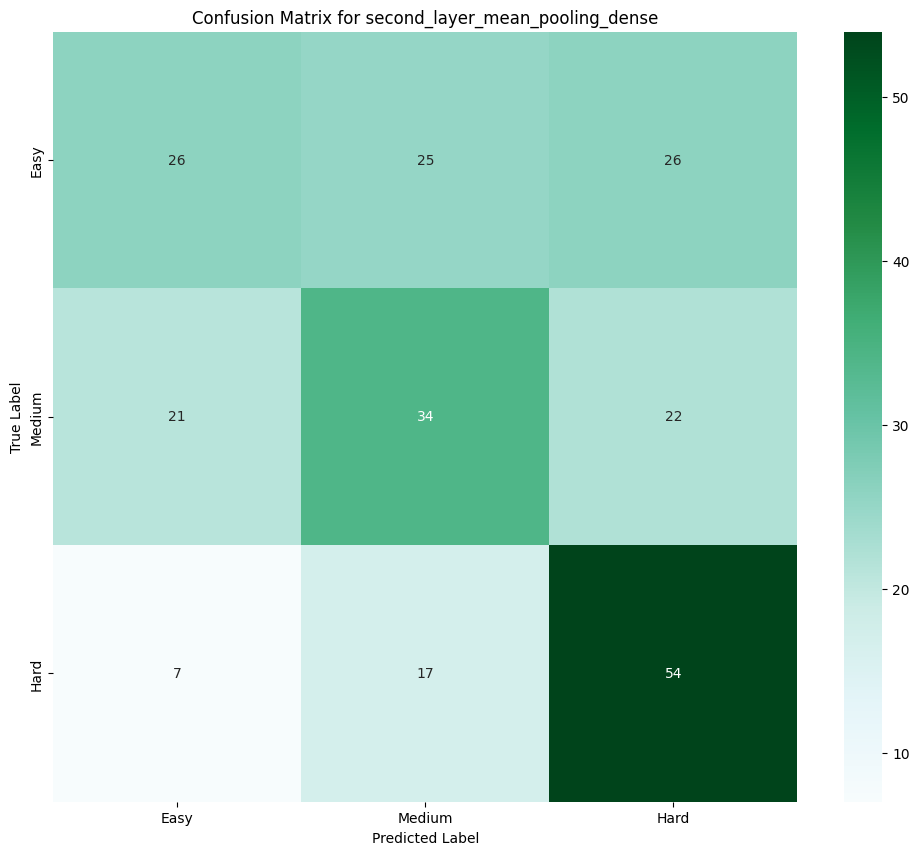

In [78]:
predicted_labels = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(12, 10))

class_labels = ['Easy', 'Medium', 'Hard']
sns.heatmap(cm, annot=True, fmt='d', cmap='BuGn', xticklabels=class_labels, yticklabels=class_labels)
plt.title(f'Confusion Matrix for {EXPERIMENT_NAME}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(f"{EXPERIMENT_NAME}.png", dpi=300)
plt.show()